## Product Backorder Prediction

Material back-order is a well-known issue that concerns the availability of a product when it is needed for further production or when a customer wishes to purchase it. Here, the prediction will identify the likelihood of having backorders, which will be very useful because such a tendency may result in the loss of a customer because it will affect timely production or product shortage when a customer wants it.

##### Business Problem: 
A manufacturing company that produces and sells products (identified by the SKU). The company has a large inventory, and they want to predict which products are likely to go on backorder in the near future so they can take preemptive measures to avoid stockouts.

##### Background:
In terms of cost, predicting and preventing backorders can have a significant impact on a company's financial performance. When a product goes on backorder, it can result in lost sales revenue, lower customer satisfaction, and potential damage to the company's reputation.

On the other hand, maintaining excessive inventory levels can also be costly. It ties up working capital, takes up valuable storage space, and increases the risk of products becoming obsolete or expiring.

Cost are as following:
The company sells 1,000 units on average per month at a price of dollar 60 per unit (avg cost).
The cost of of warehousing and maintaining these units is dollar 10 per unit per month (avg cost)


### 1.0 Import and install python libraries and Set Random Seed
Here we import any Python libraries that we plan to use.

In [23]:
# import numpy and pandas libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

np.random.seed(113)

In [24]:
# loading the source data for preprocessing
BOP_DF = pd.read_csv("BOP_DSP.csv")

### 2.0 Load the Data

Data features are as follows:

sku - Random ID for the product

national_inv - Current inventory level for the part

lead_time - Transit time for product (if available)

in_transit_qty - Amount of product in transit from source

forecast_3_month - Forecast sales for the next 3 months

forecast_6_month - Forecast sales for the next 6 months

forecast_9_month - Forecast sales for the next 9 months

sales_1_month - Sales quantity for the prior 1 month time period

sales_3_month - Sales quantity for the prior 3 month time period

sales_6_month - Sales quantity for the prior 6 month time period

sales_9_month - Sales quantity for the prior 9 month time period

min_bank - Minimum recommend amount to stock

potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

perf_6_month_avg - Source performance for prior 6 month period

perf_12_month_avg - Source performance for prior 12 month period

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

stop_auto_buy - Part risk flag

rev_stop - Part risk flag

went_on_backorder - Product actually went on backorder. This is the target value.

### 3.0 Data Exploration 

Key considerations of the data:
Imbalanced outcome: We will First figure out if the data is imbalanced or not
Missing data: We will find if any variables have data that are missing. 
n>>p: There are many observations relative to the number of predictors (22). We will also take care for dimensionality reduction

In [25]:
# look at the data
BOP_DF.head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3284988,8,8,0,0,0,0,1,3,4,...,0,0.99,0.98,0,Yes,No,No,Yes,No,No
1,3284990,7,8,0,9,20,31,1,7,16,...,0,0.97,0.93,0,No,No,No,Yes,No,No
2,3285036,76,8,8,24,64,88,11,34,91,...,0,1.00,0.99,0,No,No,No,Yes,No,No
3,3285128,16,8,0,12,12,24,1,8,19,...,0,0.98,0.98,0,No,No,No,Yes,No,No
4,3285175,0,8,0,8,18,22,2,5,15,...,0,0.87,0.80,0,No,No,No,Yes,No,No


In [26]:
BOP_DF.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [27]:
# generate a basic summary of the data
BOP_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8230 entries, 0 to 8229
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                8230 non-null   int64  
 1   national_inv       8230 non-null   int64  
 2   lead_time          8230 non-null   int64  
 3   in_transit_qty     8230 non-null   int64  
 4   forecast_3_month   8230 non-null   int64  
 5   forecast_6_month   8230 non-null   int64  
 6   forecast_9_month   8230 non-null   int64  
 7   sales_1_month      8230 non-null   int64  
 8   sales_3_month      8230 non-null   int64  
 9   sales_6_month      8230 non-null   int64  
 10  sales_9_month      8230 non-null   int64  
 11  min_bank           8230 non-null   int64  
 12  potential_issue    8230 non-null   object 
 13  pieces_past_due    8230 non-null   int64  
 14  perf_6_month_avg   8230 non-null   float64
 15  perf_12_month_avg  8230 non-null   float64
 16  local_bo_qty       8230 

In [28]:
# generate a statistical summary of the numeric value in the data
BOP_DF.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,8.230000e+03,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,3.432955e+06,334.923451,7.616403,29.324180,165.995140,303.445565,439.712029,47.124180,159.579101,302.807290,432.799271,48.449210,1.023086,-2.095063,-1.588577,1.551519
std,5.460683e+04,4822.548365,6.828169,691.169906,2879.685922,5552.571012,8231.427999,949.764117,3207.841255,6009.166066,8030.355439,1144.503728,30.203996,16.653075,15.138120,46.488555
min,3.284988e+06,-2567.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.000000,-99.000000,0.000000
25%,3.410808e+06,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680000,0.660000,0.000000
50%,3.458436e+06,9.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.820000,0.810000,0.000000
75%,3.460634e+06,43.000000,8.000000,0.000000,12.000000,22.000000,33.000000,5.000000,15.000000,30.000000,44.000000,2.000000,0.000000,0.970000,0.950000,0.000000
max,3.525576e+06,353974.000000,52.000000,47461.000000,179648.000000,331712.000000,483776.000000,57555.000000,205979.000000,388721.000000,522624.000000,86255.000000,1364.000000,1.000000,1.000000,2837.000000


In [29]:
# Check the missing values by summing the total na's for each variable
BOP_DF.isna().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [30]:
# create a list of these catagorical variables, these will be loaded from a csv file as dtype=object.
category_var_list = list(BOP_DF.select_dtypes(include='object').columns)
category_var_list

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop',
 'went_on_backorder']

### 3.1 Visualizing the data for Imbalance

Product went on backorder 1983 times 24.094775212636694 %
Product Not went on backorder 6247 times 75.90522478736331 %


([<matplotlib.patches.Wedge at 0x17ee6c8b310>,
 [Text(-0.7996199812214853, 0.7553859183433007, 'Product Not went on backorder'),
  Text(0.9450055577276103, -0.8927286798708376, 'Product went on backorder')],
 [Text(-0.43615635339353737, 0.4120286827327095, '75.9%'),
  Text(0.5815418816785294, -0.5493714953051307, '24.1%')])

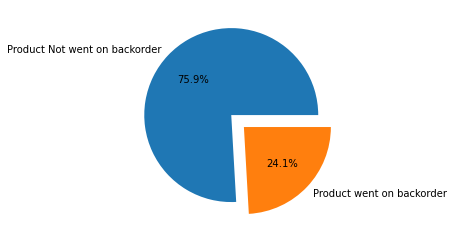

In [31]:
p = BOP_DF.went_on_backorder.value_counts()
print("Product went on backorder",p[1], "times",(p[1]*100/(p[1]+p[0])) , "%")
print("Product Not went on backorder",p[0], "times" , (p[0]*100/(p[1]+p[0])), "%")

fig, ax = plt.subplots()

labels = ['Product Not went on backorder', 
         'Product went on backorder']
explode = (0, 0.2) 
percentages = [p[0]*100/(p[1]+p[0]), p[1]*100/(p[1]+p[0])]

#Draw pie chart 
ax.pie(percentages, labels=labels, shadow=False,explode=explode,autopct='%1.1f%%')

Data distribution is imbalance since only 27.2 % labels are having output 1 (i.e.) Backorder initiated.

### 4.0 Preprocessing: 
1.Numeric features are at different scales and for some of the data range is very large so it is required to normalize such features.
2.Categorical features, all are having two possible values which are Yes and No, which can be converted into binary numbers 0 and 1. 
3. SKU is a unique number that is not important for classification and hence it can be dropped. 
4. Data is highly imbalanced and hence it should be balanced by sampling or any other method after splitting them into train and test
5. There are no NA's in the data to be taken care of

In [32]:
# Change categorical features from string to numerical
Cols_for_str_to_bool = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
                        'stop_auto_buy', 'rev_stop', 'went_on_backorder']

for col_name in Cols_for_str_to_bool:
    BOP_DF[col_name] = BOP_DF[col_name].map({'No':0, 'Yes':1})

### 4.1 Vusualizating the Corelation plot for dimensionality reduction consideration

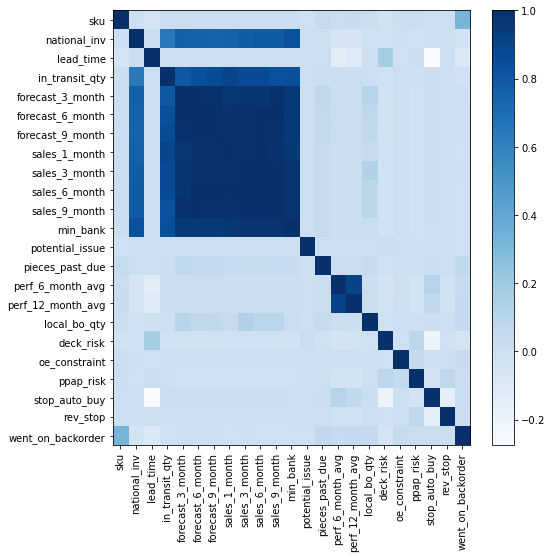

In [33]:
# Set figure size 
fig = plt.figure(figsize=(8,8)) 

# Plot a correlation matrix
plt.imshow(BOP_DF.corr(), cmap=plt.cm.Blues, interpolation='nearest', aspect='auto')

# Display legend showing what the colours mean
plt.colorbar()

# Add tick marks and feature names for ease of reading
tick_marks = [i for i in range(len(BOP_DF.columns))]
plt.xticks(tick_marks, BOP_DF.columns, rotation='vertical')
plt.yticks(tick_marks, BOP_DF.columns)

# Show the plot
plt.show()

#### Feature Selection
The dimensionality of the input is a problem.
The forecast values over each time frame have very close linear correlation with each other, as expected from the correlation matrix. Backorders only occur when the forecast value is low.
The sales over each time frame have good linear correlations with each other, as expected from the correlation matrix.Backorders only occur when sales are low.
Due to the good correlations and sufficiently linear relationships between these features, they will all be represented by a single feature in the machine learning models. The feature chosen is sales_1_month. This is because past sales is measured, whereas the quantity in transit, recommended minimum stock and forecasts are likely derived from past sales.

In [34]:
#feature selection 
BOP_DF.drop(['sales_3_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg','forecast_3_month', 
             'forecast_6_month', 'forecast_9_month'], axis=1, inplace = True)

In [35]:
# Dropping SKU
BOP_DF.drop(['sku'], axis=1, inplace = True)

In [36]:
# Replace "Yes" with "potential_issue"
BOP_DF['potential_issue'].replace(1, 'potential_issue', inplace=True)
BOP_DF['deck_risk'].replace(1, 'deck_risk', inplace=True)
BOP_DF['oe_constraint'].replace(1, 'oe_constraint', inplace=True)
BOP_DF['ppap_risk'].replace(1, 'ppap_risk', inplace=True)
BOP_DF['stop_auto_buy'].replace(1, 'stop_auto_buy', inplace=True)
BOP_DF['rev_stop'].replace(1, 'rev_stop', inplace=True)
BOP_DF['went_on_backorder'].replace(1, 'went_on_backorder', inplace=True)


### 4.2 Non ordered Dummy encoding
As for Categorical Variables is label encoded we need to change it to dummy encoding

In [37]:
# Label Encoding
BOP_DF = pd.concat([BOP_DF, pd.get_dummies(BOP_DF[category_var_list],prefix = "yes",drop_first = True)], axis=1)
BOP_DF.drop(category_var_list, axis=1, inplace = True)

In [38]:
# look at the data
BOP_DF.head(5)

,national_inv,lead_time,in_transit_qty,sales_1_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,yes_potential_issue,yes_deck_risk,yes_oe_constraint,yes_ppap_risk,yes_stop_auto_buy,yes_rev_stop,yes_went_on_backorder
0,8,8,0,1,1,0,0.99,0,0,1,0,0,1,0,0
1,7,8,0,1,3,0,0.97,0,0,0,0,0,1,0,0
2,76,8,8,11,25,0,1.00,0,0,0,0,0,1,0,0
3,16,8,0,1,0,0,0.98,0,0,0,0,0,1,0,0
4,0,8,0,2,0,0,0.87,0,0,0,0,0,1,0,0


###  4.3 Split data (train/test)
Splitting the data into two sets train and test for model training and testing.

In [39]:
# split the data into validation and training set
train_df, test_df = train_test_split(BOP_DF, test_size=0.3)

# to reduce repetition in later code, creating variables to represent the columns
# that are predictors and target
target = 'yes_went_on_backorder'
predictors = list(BOP_DF.columns)
predictors.remove(target)

### 4.4 Standardize numeric values

Create a common scale between the numberic columns by standardizing each numeric column

In [40]:
# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
cols_to_stdize = ['national_inv', 'lead_time', 'in_transit_qty', 'sales_1_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'local_bo_qty']                
               
# Transform the predictors of training and validation sets
train_df[cols_to_stdize] = scaler.fit_transform(train_df[cols_to_stdize]) # train_predictors is not a numpy array

test_df[cols_to_stdize] = scaler.transform(test_df[cols_to_stdize]) # validation_target is now a series object

In [41]:
X_train = train_df[predictors]
y_train = train_df[target] # train_target is now a series object
X_test = test_df[predictors]
y_test = test_df[target] # validation_target is now a series object

In [42]:
y_train.value_counts()

0    4366
1    1395
Name: yes_went_on_backorder, dtype: int64

### 4.5  Data Balancing

We will utilize an oversamplying technique to address any necessary date balancing.
Oversampled data perform well as compared to Undersampled data,because of loss of data while undersampling.

In [43]:
# transform the dataset using over sampeling to hadel imbalanced data 
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(sampling_strategy = 'minority')
X_train, y_train = os.fit_resample(X_train, y_train)
y_train.value_counts()

1    4366
0    4366
Name: yes_went_on_backorder, dtype: int64

### 4.0 Saving the data

In [44]:
train_df.to_csv('./bop_train_df.csv', index=False)
X_train.to_csv('./bop_X_train.csv', index=False)
y_train.to_csv('./bop_y_train.csv', index=False)
test_df.to_csv('./bop_test_df.csv', index=False)
X_test.to_csv('./bop_X_test.csv', index=False)
y_test.to_csv('./bop_y_test.csv', index=False)